## 1. 작업환경을 현재 위치로 옮긴다.

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 2. 필요한 패키지들을 불러온다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, ReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model

In [4]:
from utils.datagenerator_girls_imgaug_all import TightFaceProvider
from utils.helper_girls import glob_all_files, paths2numpy, images_cropper, draw_rectangles
from utils.helper_girls import show_images, cropper, random_patch

## 3. 학습용 데이터를 불러온 후 인공지능 모델 학습에 알맞게 가공해준다.

Max Height : 35 	 Min Height : 19
Max Width : 26 	 Min Width : 16
Max W/H Ratio : 1.2105263157894737 	 Min Ratio : 0.6071428571428571


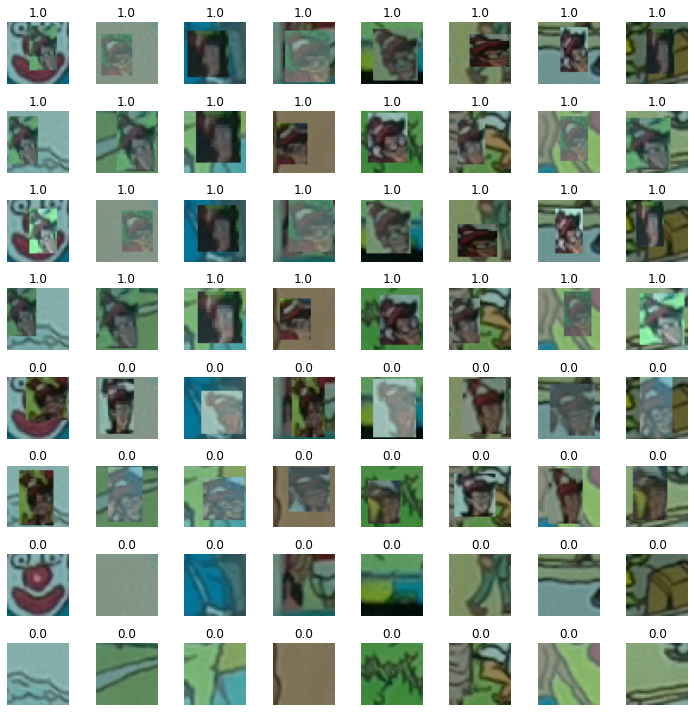

In [5]:
wally_folder = './new_crop_data/face/wally/'
girl_folder = './new_crop_data/face/girl/'
bg_folder = './new_crop_data/train_imgs/'

#from utils.helper_imaug import random_imaug
#fg_imgs = paths2numpy(glob_all_files(fg_folder))
#show_images(random_imaug(fg_imgs))
tfp0315 = TightFaceProvider(wally_folder, girl_folder, bg_folder, batch_size=32)
show_images(tfp0315[0][0], titles=tfp0315[0][1].tolist())

## 4. 학습 모델을 구축한다.

In [6]:
inputs = Input(shape=(36, 36, 3), name='inputs')

conv = Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer='he_normal')(inputs)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

conv = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(pool)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

conv = Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer='he_normal')(pool)
norm = BatchNormalization()(conv)
relu = ReLU()(norm)
pool = MaxPooling2D()(relu)

flat = Flatten()(pool)

#
fcn1 = Dense(units=256, kernel_initializer='he_normal')(flat)
norm = BatchNormalization()(fcn1)
relu = ReLU()(norm)

#
fcn2 = Dense(units=256, kernel_initializer='he_normal')(relu)
norm = BatchNormalization()(fcn2)
relu = ReLU()(norm)

#
pred = Dense(units=1, activation='sigmoid')(relu)

# Model
model = Model(inputs, pred)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

## 5. 모델을 학습시킨다.

In [7]:
model.fit(tfp0315, epochs=1)

16412/30560 [===============>..............] - ETA: 23:38 - loss: 0.0030 - accuracy: 0.9989

KeyboardInterrupt: 

## 6. 모델을 저장한다.

In [8]:
model.save("./models/test_girls_back_imgaug")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/test_girls_back_imgaug/assets


## 7. 이미 저장된 모델이 있을 경우, 그 모델을 불러온다.

In [39]:
model = load_model("./models/the_best_model")

## 8. 검증용 데이터를 불러온다.

In [9]:
val_folder = "./new_crop_data/test_imgs"
paths = glob_all_files(val_folder)

assert paths, print("올바른 경로가 아니거나, 경로 내에 검증용 이미지가 존재하지 않습니다.")

imgs = paths2numpy(paths)

bucket_crop_imgs, bucket_crop_crds = images_cropper(imgs, 10, 10, 36, 36)

## 9. 모델을 검증용 데이터로 테스트합니다.

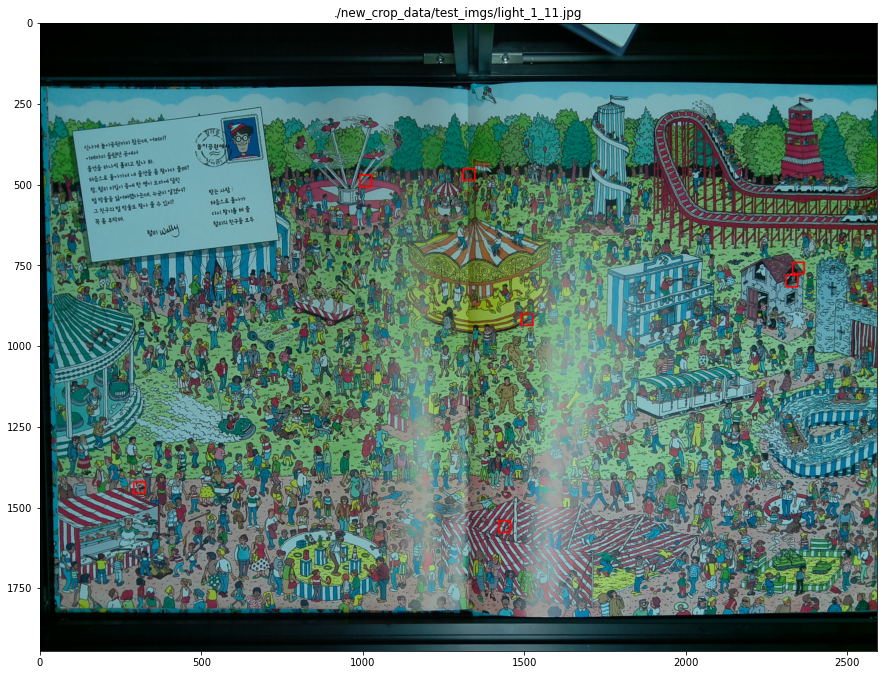

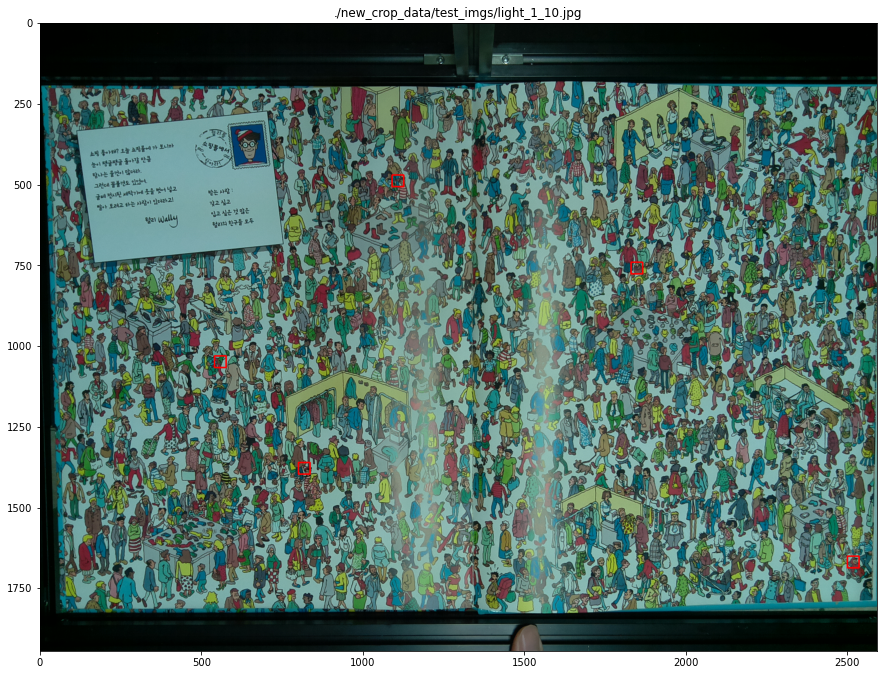

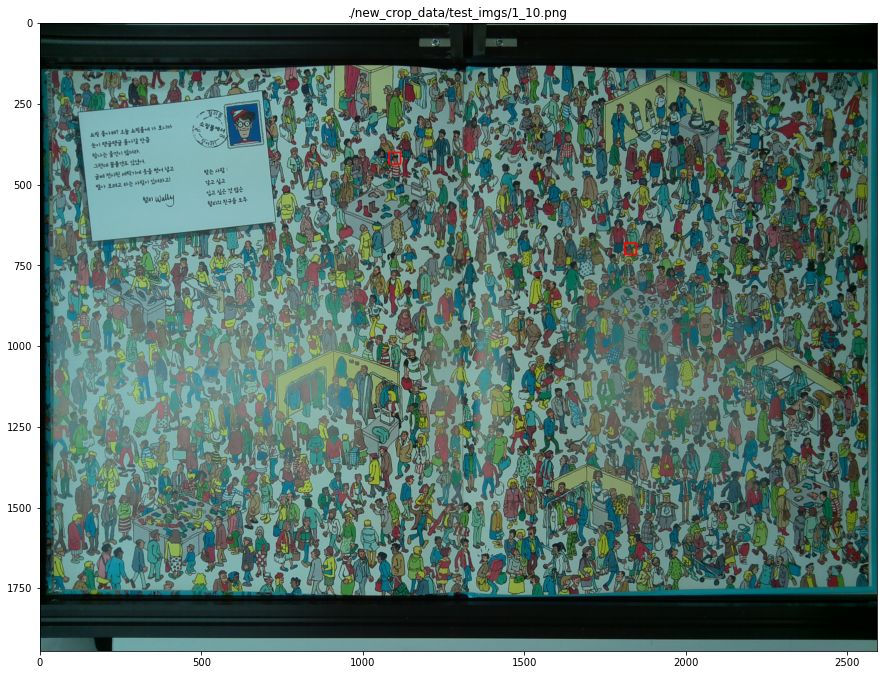

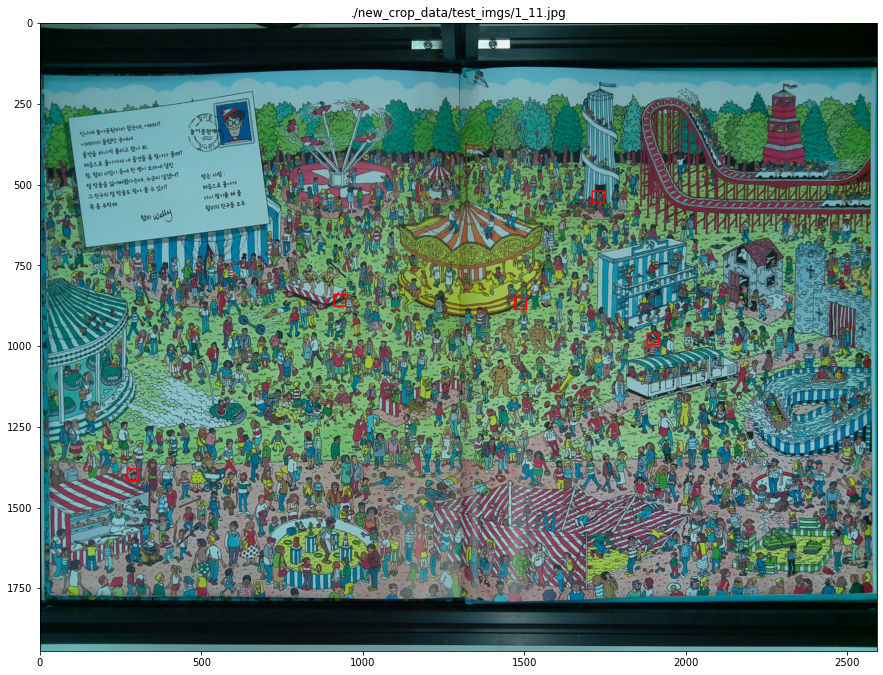

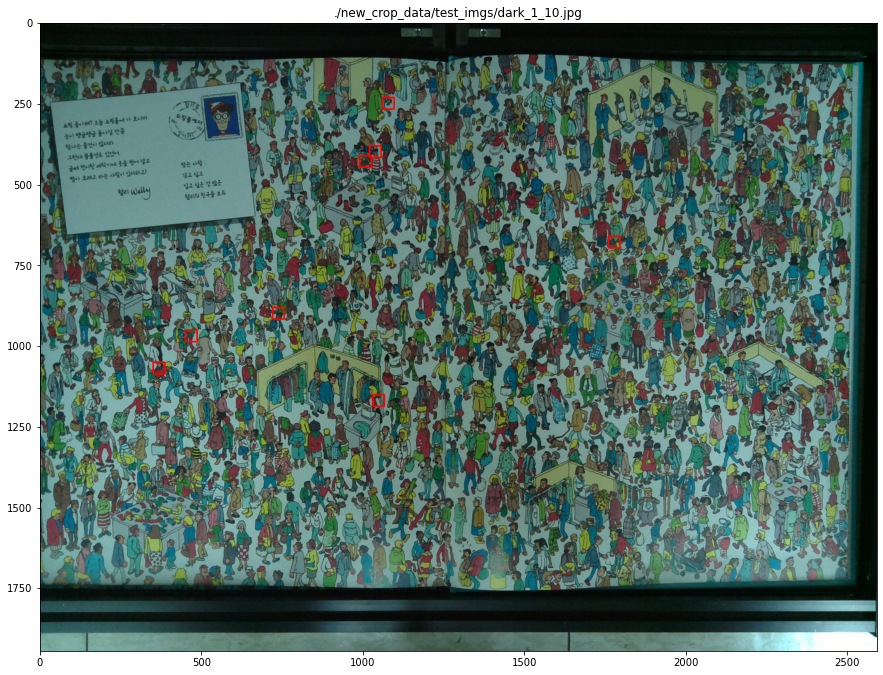

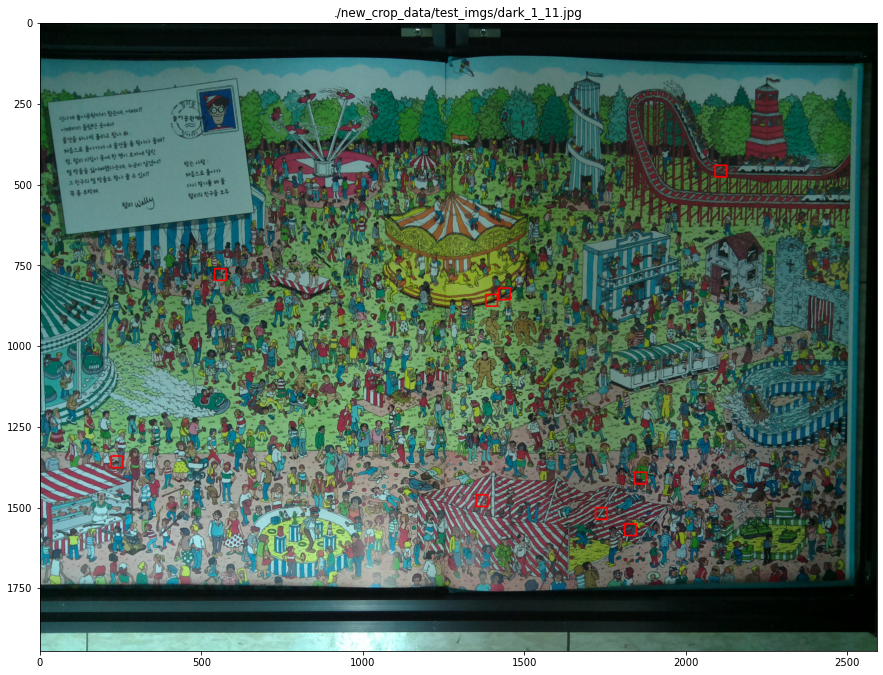

In [10]:
for i, img in enumerate(imgs):
    cropped_imgs = bucket_crop_imgs[i]
    cropped_crds = bucket_crop_crds[i]

    # 예측값을 저장한 후, 그 중 0.5가 넘는 값들에 대한 불리언 마스크를 만드는 부분입니다.
    predicts = model.predict(cropped_imgs)
    bool_mask = (predicts > 0.5)[:, 0]

    #show_images(cropped_imgs[bool_mask])    # 불리언 마스크를 적용시킨 결과로 얻은 월리의 얼굴로 추정되는 이미지 조각들을 출력
    target_crds = np.array(cropped_crds)[bool_mask]     # 월리의 얼굴이 있을 것으로 예상되는 좌표들을 저장

    predicts = predicts[bool_mask]  # 불리언 마스크를 적용시켰을 때의 예측값을 저장
    result_image = draw_rectangles(img, target_crds, (255, 0, 0), 3, predicts[:, 0])
    
    plt.figure(figsize=(15, 15))
    plt.title(paths[i])
    plt.imshow(result_image)
    plt.show()
